## **SNR and resolution comparison**
---
#### Overview
- Calculate spectral signal-to-noise ratio (SSNR) and resolution for different detection methods (BSE, SE and optical STEM)
- Compare results
- Also compare to 0.5nm pixel size to see if they are similar, making sure that the decreased probe size for optical STEM does not affect the measurements

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import img_as_float, img_as_ubyte
from skimage.util import crop
from skimage import exposure
import tifffile as tf
import pandas as pd
import re
import os
import seaborn as sns
import altair as alt
from tqdm.notebook import tqdm

In [3]:
#Local imports
import sys
# Add code directory to path
code_dir = '../code/'
if code_dir not in sys.path:
    sys.path.insert(1, code_dir)
# Import ssnr code
import ssnr
from resolution import RES_JOY

In [4]:
%config Completer.use_jedi = False
HFW = 3.072 # micrometers
pd.set_option("display.max_rows", None)
cut_off_freq = 100 # Cut-off spatial frequency (val * 1/nm) for Fourier Filtering of OSTEM data

## 1. Load all image data
---

In [1]:
# Find directory
DATA_dir = Path("../data/3_SNR-comparison-detectors/")

# Select files and initialize DataFrame with image locations
files = [fn for fn in DATA_dir.glob('*[!_]/*.tif') 
         if not fn.parent.name == '_Qualitative']
df_im = pd.DataFrame({'FilePos': files})

# Build up DataFrame
df_im['DetectionMode'] = df_im['FilePos'].apply(lambda x: x.parent.name.split('_')[0])
df_im['Mode'] = df_im['FilePos'].apply(lambda x: x.parents[1].name)
df_im['LE'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[1].split('kV')[0])
df_im['Dwell'] =  df_im['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# List values in ascending order
df_im['Dwell'] = df_im['Dwell'].astype(float)
df_im = df_im.sort_values(['DetectionMode', 'Dwell'], ascending=[True, True])

# Preview
df_im.sort_values(['DetectionMode', 'LE'], inplace=True)
df_im.sample(5)

NameError: name 'Path' is not defined

In [120]:
# Circular mask function for Fourier filtering
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(h/2), int(w/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    mask = dist_from_center <= radius # mask everything above cut-off freq
    
    return mask

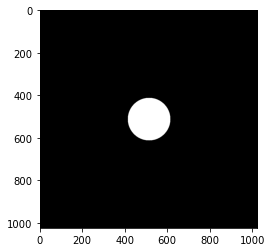

In [87]:
mask = create_circular_mask(1024, 1024, center=None, radius=cut_off_freq)
plt.imshow(mask, cmap='gray')

## 2. Perform SSNR measurements (no contrast enhancement)
---

In [11]:
# Initialize DataFrame for SNR
df_snr = pd.DataFrame(columns=['FilePos','DetectionMode', 'LE', 'Dwell', 'SSNR', 'SNR_Joy'])

# Loop through bioimages
for i, row in tqdm(df_im.iterrows(), total=len(df_im)):

    # Load and crop images
    image = img_as_float(tf.imread(row['FilePos'].as_posix()))
    image = image[:1024, :1536]
    
    # Compute SNR from SSNR
    images = ssnr.split_image_rows(image) # Split into rows to avoid streaking effect
    snr = ssnr.SSNR_full(images)
    
    # Compute SNR from Joy 
    snr_joy = ssnr.SNR_JOY(image)

    # Populate DataFrame
    df_snr.loc[i, 'FilePos'] = row['FilePos']
    df_snr.loc[i, 'DetectionMode'] = row['DetectionMode']
    df_snr.loc[i, 'LE'] = row['LE']
    df_snr.loc[i, 'Dwell'] = row['Dwell']
    df_snr.loc[i, 'SSNR'] = snr
    df_snr.loc[i, 'SNR_Joy'] = snr_joy
    df_snr.loc[i, 'Mode'] = row['Mode']
    
# Preview
df_snr = df_snr.infer_objects()
df_snr.groupby('DetectionMode')\
      .apply(lambda x: x[::len(df_snr)//10])

  0%|          | 0/395 [00:00<?, ?it/s]

FilePos  \
DetectionMode                                                          
ADF-STEM      24   ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              43   ..\data\3_SNR-comparison-detectors\SNR-final-c...   
BSD           76   ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              278  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              244  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
BSD-SB        125  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              313  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              114  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
OSTEM         174  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              353  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              316  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
SE            214  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              394  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              358  ..\data\3_SNR-comparison-detectors\SNR-final-c...   

                  DetectionMode   LE    Dwell       SSNR    SNR_Joy Mode  
DetectionMode                                                             
ADF-STEM      24       ADF-STEM   28    100.0   2.675275   2.808229   HR  
              43       ADF-STEM   28   3000.0  22.812647  10.575935   HR  
BSD           76            BSD  1.5    100.0   0.008968   0.051123   HR  
              278           BSD  1.5    500.0   0.006760   0.007192  UHR  
              244           BSD  1.5  10000.0   1.343967   1.030732  UHR  
BSD-SB        125        BSD-SB  1.5    100.0  -0.007550   0.011169   HR  
              313        BSD-SB  1.5    500.0   0.243262   0.223800  UHR  
              114        BSD-SB  1.5  10000.0  14.594629  13.014304   HR  
OSTEM         174         OSTEM    4    100.0   0.212256   0.205962   HR  
              353         OSTEM    4    500.0   0.128093   0.121753  UHR  
              316         OSTEM    4  10000.0   0.972993   0.753642  UHR  
SE            214            SE  1.5    100.0   0.032868   0.030939   HR  
              394            SE  1.5    500.0   0.095453   0.093426  UHR  
              358            SE  1.5  10000.0   2.024598   1.663132  UHR

In [12]:
df_snr.to_csv('snr_values_new.csv',index=True)

In [8]:
df_snr = pd.read_csv('snr_values_new.csv')
df_snr.groupby('DetectionMode')\
      .apply(lambda x: x[::len(df_snr)//10])

Unnamed: 0  \
DetectionMode                   
ADF-STEM      0            24   
              39           43   
BSD           64           76   
              103         278   
              142         244   
BSD-SB        147         125   
              186         313   
              225         114   
OSTEM         234         174   
              273         353   
              312         316   
SE            315         214   
              354         394   
              393         358   

                                                             FilePos  \
DetectionMode                                                          
ADF-STEM      0    ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              39   ..\data\3_SNR-comparison-detectors\SNR-final-c...   
BSD           64   ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              103  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              142  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
BSD-SB        147  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              186  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              225  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
OSTEM         234  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              273  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              312  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
SE            315  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              354  ..\data\3_SNR-comparison-detectors\SNR-final-c...   
              393  ..\data\3_SNR-comparison-detectors\SNR-final-c...   

                  DetectionMode    LE    Dwell       SSNR    SNR_Joy Mode  
DetectionMode                                                              
ADF-STEM      0        ADF-STEM  28.0    100.0   2.675275   2.808229   HR  
              39       ADF-STEM  28.0   3000.0  22.812647  10.575935   HR  
BSD           64            BSD   1.5    100.0   0.008968   0.051123   HR  
              103           BSD   1.5    500.0   0.006760   0.007192  UHR  
              142           BSD   1.5  10000.0   1.343967   1.030732  UHR  
BSD-SB        147        BSD-SB   1.5    100.0  -0.007550   0.011169   HR  
              186        BSD-SB   1.5    500.0   0.243262   0.223800  UHR  
              225        BSD-SB   1.5  10000.0  14.594629  13.014304   HR  
OSTEM         234         OSTEM   4.0    100.0   0.212256   0.205962   HR  
              273         OSTEM   4.0    500.0   0.128093   0.121753  UHR  
              312         OSTEM   4.0  10000.0   0.972993   0.753642  UHR  
SE            315            SE   1.5    100.0   0.032868   0.030939   HR  
              354            SE   1.5    500.0   0.095453   0.093426  UHR  
              393            SE   1.5  10000.0   2.024598   1.663132  UHR

In [7]:
plt.imshow(image)

NameError: name 'image' is not defined

In [11]:
### Compute relative increase in SNR 

## 3. Perform SSNR measurements (with contrast enhancement)
---

In [12]:
# # Initialize DataFrame for SNR
# df_snr2 = pd.DataFrame(columns=['DETECTION_MODE', 'kV', 'SSNR'])

# # Loop through bioimages
# for i, row in df_im.iterrows():

#     # Load and crop images
#     image = img_as_float(tf.imread(row['FilePos'].as_posix()))
#     crop_width = (((image.shape[0] - 1024) // 2,) * 2,
#                   ((image.shape[1] - 1024) // 2,) * 2)
#     cropped = crop(image, crop_width=crop_width, copy=True)
    
#     # Perform contrast enhancement if not STEM image
#     if row['DETECTION_MODE'] != 'STEM':
#         p2, p98 = np.percentile(cropped, (2, 98))
#         img = exposure.rescale_intensity(cropped, in_range=(p2, p98))
#     else: 
#         img = cropped

#     # Compute SNR from SSNR
#     images = ssnr.split_image(img)
#     snr = ssnr.SSNR_full(images)

#     # Populate DataFrame
#     df_snr2.loc[i, 'DETECTION_MODE'] = row['DETECTION_MODE']
#     df_snr2.loc[i, 'kV'] = row['kV']
#     df_snr2.loc[i, 'SSNR'] = snr

# # Preview
# df_snr2 = df_snr2.infer_objects()
# df_snr2.groupby('DETECTION_MODE')\
#       .apply(lambda x: x[::len(df_snr)//10])

## 4. Plot comparison between detection methods
---

In [13]:
# The contrast has been stretched digitally for the optical STEM signal already. To see the effect on this on SSNR, we contrast stretched all images
# Left: no contrast stretching. Right: maximum contrast stretching (digitally)

sns.set_theme(style="darkgrid")
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig = plt.figure(figsize=(8,8))
#ax1.set_title('No contrast enhancement for BSE, SE and BSE-SB',fontsize=20)
sns.pointplot(x='DETECTION_MODE', y="SNR", data=df_snr, join=False, capsize=.1)
plt.yscale('log')
plt.ylim(0.01,10)
plt.yticks((0.01,0.1,1,10))
#ax2.set_title('Contrast enhancement for all images', fontsize=20)
#sns.pointplot(x='DETECTION_MODE', y="SSNR", data=df_snr2, join=False, capsize=.1, ax=ax2)
plt.savefig("SNR_comparison", dpi=300)

ValueError: Could not interpret input 'SNR'

<Figure size 576x576 with 0 Axes>

### Plot SSNR comparison 

In [9]:
# Filter data 
Mode = 'HR'
source = df_snr.loc[(df_snr['Mode'].isin([Mode])) &\
                           (df_snr['SSNR'] > 0.001)]\
                      .reset_index()\
                      .copy()
source.sample(5)

,index,Unnamed: 0,FilePos,DetectionMode,LE,Dwell,SSNR,SNR_Joy,Mode
113,180,162,..\data\3_SNR-comparison-detectors\SNR-final-c...,BSD-SB,1.5,500.0,0.204427,0.180724,HR
160,268,202,..\data\3_SNR-comparison-detectors\SNR-final-c...,OSTEM,4.0,500.0,0.228288,0.207262,HR
179,307,166,..\data\3_SNR-comparison-detectors\SNR-final-c...,OSTEM,4.0,10000.0,2.700016,2.348646,HR
136,223,112,..\data\3_SNR-comparison-detectors\SNR-final-c...,BSD-SB,1.5,10000.0,10.162218,9.654398,HR
32,32,36,..\data\3_SNR-comparison-detectors\SNR-final-c...,ADF-STEM,28.0,3000.0,20.228619,18.774456,HR


In [10]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.colors as mcolors
from matplotlib import cycler
import matplotlib as mpl

import matplotlib.ticker as plticker

In [11]:
plt.style.use('tableau-colorblind10')

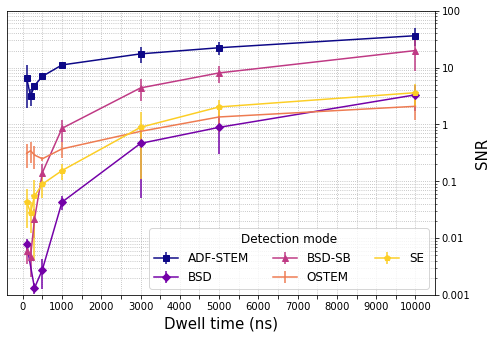

In [50]:
# Make figure
colours = 0.18*len(source.DetectionMode.unique())
cmap = plt.get_cmap('plasma')
#cmap = plt.get_cmap('tableau-colorblind10')
mpl.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 0.9, len(source['DetectionMode'].unique()))))
fig, ax = plt.subplots(figsize=(7, 4.8)) # 8, 4.8 default
legend = source.DetectionMode.unique()
fs=15 # 15 default
if Mode == 'HR':
    marker=["s","D","^","","p"]
else:
    marker=["D","^","","p"]
# Group by dwell time
for (mode, images), marker in zip(source.groupby(by=['DetectionMode']), marker):
    
    # Calculate mean and std of SSNR
    mean = images.groupby(by=['Dwell'])['SSNR'].mean()
    std = images.groupby(by=['Dwell'])['SSNR'].std()
    
    # Plot 
    ax.errorbar(images.Dwell.unique(), mean, yerr=std, marker=marker, markersize=6, lw=1.5)
    
# Axis aesthetics
ax.set_yscale('log')
ax.set_ylim([1e-3, 1e2])
ax.grid(which='both', ls=':') 
ax.grid(which='both', ls=':') 
ax.legend(legend, title='Detection mode', fontsize=fs-3, title_fontsize=fs-3, loc='lower right', ncol=3)
ax.set_xlabel('Dwell time (ns)',fontsize=fs)
ax.set_ylabel('SNR', fontsize=fs)
for axis in [ax.xaxis, ax.yaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    axis.set_major_formatter(formatter)

# Tidy up axes
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

loc = plticker.MultipleLocator(base=500) # this locator puts ticks at regular intervals, default 500
ax.xaxis.set_major_locator(loc)


for label in ax.yaxis.get_minorticklabels():
    label.set_visible(False) 

for label in ax.xaxis.get_majorticklabels()[0::2]:
    label.set_visible(False)
    
plt.tight_layout()
plt.savefig(f'SSNR_comparison_{source.Mode.unique()[0]}_presentation', dpi=300)

### Plot SNR (SSNR) with altair

In [111]:
# Data source for plot
source = df_snr.loc[df_snr['SSNR'] > 0.001].copy()
# source = df_snr.copy()
scheme = 'category10'

chart = alt.Chart().encode(
    x=alt.X('DWELL TIME (ns)',
            axis=alt.Axis(title='Dwell time (ns)')),
    y=alt.Y('SSNR',
            aggregate='mean',
            scale=alt.Scale(domain=[0.001, 100], type='log')),
    color=alt.Color('Detection mode:N',
                    scale=alt.Scale(scheme=scheme),
                    )
).properties(width=800,
             height=400)

chart = (chart.mark_line() +\
         chart.mark_point(size=40))

error_bars = alt.Chart().mark_errorbar(extent='stdev').encode(
    x=alt.X('DWELL TIME (ns)'),
    y=alt.Y('SSNR'),
    color=alt.Color('Detection mode',
                    scale=alt.Scale(scheme=scheme))
)

alt.layer(chart, error_bars, data=source).configure_axis(
    labelFontSize=26,
    titleFontSize=26
).configure_legend(labelLimit=0, 
                   titleFontSize=20,
                   labelFontSize=20,
                   orient='right'
                   )


alt.LayerChart(...)

### Plot SNR (Joy)

In [112]:
# Data source for plot
source = df_snr.loc[df_snr['SNR (Joy)'] > 0.001].copy()
# source = df_snr.copy()
scheme = 'category10'

chart = alt.Chart().encode(
    x=alt.X('DWELL TIME (ns)',
            axis=alt.Axis(title='Dwell time (ns)')),
    y=alt.Y('SNR (Joy)',
            aggregate='mean',
            scale=alt.Scale(domain=[0.001, 20], type='log')),
    color=alt.Color('Detection mode:N',
                    scale=alt.Scale(scheme=scheme),
                    )
).properties(width=800,
             height=400)

chart = (chart.mark_line() +\
         chart.mark_point(size=40))

error_bars = alt.Chart().mark_errorbar(extent='stdev').encode(
    x=alt.X('DWELL TIME (ns)'),
    y=alt.Y('SNR (Joy)'),
    color=alt.Color('Detection mode:N',
                    scale=alt.Scale(scheme=scheme))
)

alt.layer(chart, error_bars, data=source).configure_axis(
    labelFontSize=26,
    titleFontSize=26
).configure_legend(labelLimit=0, 
                   titleFontSize=20,
                   labelFontSize=20,
                   orient='bottom'
                   
                   )


alt.LayerChart(...)

### Plot one image per detection technique per dwell time

In [218]:
# Find directory
Mode = 'HR'
DATA_dir = Path(f"../data/3_SNR-comparison-detectors/SNR-final-combined/{Mode}/_Qualitative")

# Select files and initialize DataFrame with image locations
df_qual = pd.DataFrame({'FilePos': list(DATA_dir.glob('*.tif'))})

# Build up DataFrame
df_qual['DetectionMode'] = df_qual['FilePos'].apply(lambda x: x.name.split('_')[0])
df_qual['LE'] = df_qual['FilePos'].apply(lambda x: x.name.split('_')[1])
df_qual['Dwell'] = df_qual['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# List values in ascending order
df_qual['Dwell'] = df_qual['Dwell'].astype(float)
df_qual = df_qual.sort_values(['DetectionMode', 'Dwell'], ascending=[True, True])

# Preview
df_qual.sort_values(['DetectionMode', 'LE'], inplace=True)
df_qual.sample(5)

,FilePos,DetectionMode,LE,Dwell
13,..\data\3_SNR-comparison-detectors\SNR-final-c...,OSTEM,4kV,3000.0
22,..\data\3_SNR-comparison-detectors\SNR-final-c...,STEM,28kV,100.0
14,..\data\3_SNR-comparison-detectors\SNR-final-c...,OSTEM,4kV,300.0
6,..\data\3_SNR-comparison-detectors\SNR-final-c...,BSE,1.5kV,1000.0
16,..\data\3_SNR-comparison-detectors\SNR-final-c...,SE,1.5kV,1000.0


In [219]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar

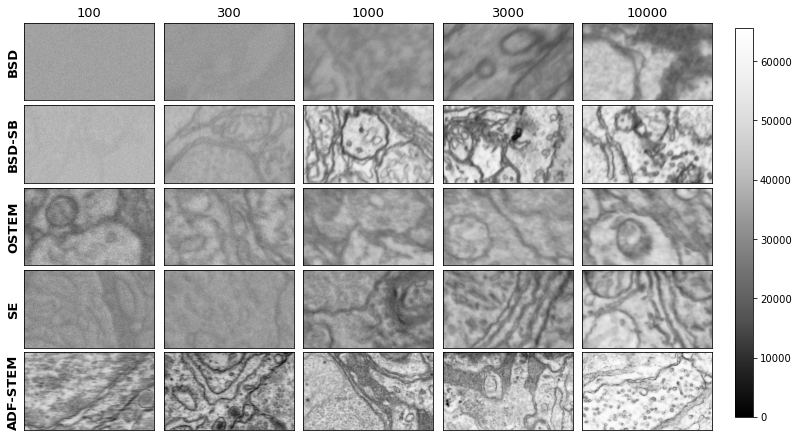

In [220]:
df_qual['Dwell'] = df_qual['Dwell'].astype(int)
source = df_qual.copy()
legend = ['BSD','BSD-SB','OSTEM','SE','ADF-STEM']
fs = 13

# Make figure (Dwell time)
nrows = df_qual['DetectionMode'].unique().size 
ncols = df_qual['Dwell'].unique().size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=True,
                         figsize=(2.5*ncols, 1.5*nrows))
plt.subplots_adjust(hspace=0.06)
plt.subplots_adjust(wspace=0.00)
axmap = {k: v for k, v in zip(source['Dwell'].unique(), axes.T)}

# Iterate through subsets of inidivual values for kV
for DT, grp in source.groupby('Dwell'):
    
    ax = axmap[DT]
    # Choose one image per subset (landing energy) to plot
    for k, row in grp.groupby('DetectionMode').apply(lambda x: x).reset_index().iterrows():
        im = img_as_float(tf.imread(row['FilePos'].as_posix()))
        cropped = im[:920,:1536]
        cropped_norm = ((cropped - cropped.min()) / (cropped.max() - cropped.min()))*65565
        image = ax[k].imshow(cropped_norm, cmap='Greys_r')
        
        # Axes aesthetics
        #ax[k].axis("off")
        ax[k].set_xticks([], [])
        ax[k].set_yticks([], [])
        if DT == 100.0:
            ax[k].set_ylabel(legend[k], fontsize=fs, weight='bold')
            # scalebar = ScaleBar(0.001, "um", length_fraction=0.4, font_properties={"size": 10},
            #                     location='lower left')
            # ax[k].add_artist(scalebar)
    
    # Axes aesthetics
    title = f"{DT}"
    ax[0].set_title(title, fontsize=fs)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.72])
cbar = fig.colorbar(image, cax=cbar_ax)
plt.savefig(f'im_comparison_{Mode}', dpi=300)

In [91]:
for i, row in grp.groupby('DETECTION_MODE').apply(lambda x: x.sample(1)).iterrows():
    print(i[0])

BSE
BSE-SB
OSTEM
SE
STEM
